# Assignment 3: Recurrent Neural Networks for Stock Price Prediction

## Setup

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset, TensorDataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

from itertools import product
from collections import Counter

from preprocessing import StockDataset
from training_evaluation import train_and_evaluate, evaluate, plot_loss_curve, plot_metrics
from optimisation import HyperparameterOptimizer

In [2]:
# Choosing the GPU as device
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# print(f"Using device: {device}")

## 1. Exploring and Preparing the Data

In [3]:
# Loading and preparing the data
RNNData = StockDataset(
    dataset_files=["archive-2/Google_Stock_Price_Train.csv", "archive-2/Google_Stock_Price_Test.csv"],
    time_steps=30,
    forecast_steps=1,
    batch_size=32,
    test_ratio=0.1,
)

Missing values for each feature:
Series([], dtype: int64)
Preprocessing of the dataset finalised and ready to train.


In [4]:
# Checking the dataset
RNNData.info()

Training Set: 992 samples
Validation Set: 98 samples
Test Set: 98 samples
Using all features: True
Time Steps: 30, Forecast Steps: 1


In [5]:
# Checking the datatypes
RNNData.check_dtypes()

Datatypes of the features:
Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
dtype: object


In [6]:
# Checking the shape of the datasets
print('Train dataset:', RNNData.X_train.shape)
print('Validation dataset:', RNNData.X_val.shape)
print('Test dataset:', RNNData.X_test.shape)

Train dataset: (992, 30, 5)
Validation dataset: (98, 30, 5)
Test dataset: (98, 30, 5)


In [7]:
# Explore the raw dataset
RNNData.raw_data

,Date,Open,High,Low,Close,Volume
0,2012-01-03,325.25,332.83,324.97,663.59,7380500
1,2012-01-04,331.27,333.87,329.08,666.45,5749400
2,2012-01-05,329.83,330.75,326.89,657.21,6590300
3,2012-01-06,328.34,328.77,323.68,648.24,5405900
4,2012-01-09,322.04,322.29,309.46,620.76,11688800
...,...,...,...,...,...,...
1273,2017-01-25,829.62,835.77,825.06,835.67,1494500
1274,2017-01-26,837.81,838.00,827.01,832.15,2973900
1275,2017-01-27,834.71,841.95,820.44,823.31,2965800
1276,2017-01-30,814.66,815.84,799.80,802.32,3246600


In [8]:
# Checking the dataloader
print(f"Number of batches - Training DataLoader: {len(RNNData.train_loader)}")
print(f"Number of batches - Validation DataLoader: {len(RNNData.val_loader)}")
print(f"Number of batches - Test DataLoader: {len(RNNData.test_loader)}")


Number of batches - Training DataLoader: 31
Number of batches - Validation DataLoader: 4
Number of batches - Test DataLoader: 4


## 2.Model Implementation and Experiments

### 2.1 Different Architectures for Experiments

In [9]:
# Simple architecture

class SimpleModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.0, rnn_type='RNN'):
        super(SimpleModel, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        else:
            self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)

        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        rnn_out, _ = self.rnn(x)
        out = rnn_out[:, -1, :]
        out = self.fc(out)
        return out


In [10]:
# Experimental architecture with dropout

class DropoutModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.0, rnn_type='RNN'):
        super(DropoutModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        
        self.rnn_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()
        
        for i in range(num_layers):
            if rnn_type == 'LSTM':
                rnn_layer = nn.LSTM(input_size if i == 0 else hidden_size, 
                                  hidden_size, 
                                  batch_first=True)
            elif rnn_type == 'GRU':
                rnn_layer = nn.GRU(input_size if i == 0 else hidden_size, 
                                 hidden_size, 
                                 batch_first=True)
            else:
                rnn_layer = nn.RNN(input_size if i == 0 else hidden_size, 
                                 hidden_size, 
                                 batch_first=True)
            
            self.rnn_layers.append(rnn_layer)
            if dropout > 0:
                self.dropout_layers.append(nn.Dropout(dropout))
        
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        hidden = None
        for i, rnn_layer in enumerate(self.rnn_layers):
            x, hidden = rnn_layer(x)
            if i < len(self.dropout_layers):
                x = self.dropout_layers[i](x)
        
        out = x[:, -1, :]
        out = self.fc(out)
        return out



In [11]:
# Experimental architecture with additional fully connected layer

class FCLayerModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.0, rnn_type='RNN', fc_size=64):
        super(FCLayerModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        else:
            self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

        # Fully Connected layer
        self.fc1 = nn.Linear(hidden_size, fc_size)
        self.fc2 = nn.Linear(fc_size, output_size)

    def forward(self, x):
        rnn_out, _ = self.rnn(x)
        out = rnn_out[:, -1, :]

        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out


In [12]:
# Experimental architecture with additional RNN layer

class MultiLayerModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.2, rnn_type='RNN'):
        super(MultiLayerModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        # RNN-Type (RNN, GRU, LSTM)
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        else:
            self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout, bidirectional=True)

        # Fully Connected Layer
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

        # Dropout Layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        rnn_out, _ = self.rnn(x)

        out = rnn_out[:, -1, :]
        out = self.dropout(out)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out

### 2.2 Baseline: Vanilla RNN

Epoch [1/100], Train Loss: 0.2889, Validation Loss: 0.1104, MSE: 0.1022, MAE: 0.2658, RMSE: 0.3197, R²: -2.3143
Epoch [2/100], Train Loss: 0.1173, Validation Loss: 0.0449, MSE: 0.0344, MAE: 0.1370, RMSE: 0.1855, R²: 0.1435
Epoch [3/100], Train Loss: 0.1065, Validation Loss: 0.0313, MSE: 0.0340, MAE: 0.1308, RMSE: 0.1844, R²: 0.3883
Epoch [4/100], Train Loss: 0.1012, Validation Loss: 0.0501, MSE: 0.0362, MAE: 0.1541, RMSE: 0.1903, R²: 0.1099
Epoch [5/100], Train Loss: 0.1003, Validation Loss: 0.0314, MSE: 0.0321, MAE: 0.1212, RMSE: 0.1792, R²: 0.4570
Epoch [6/100], Train Loss: 0.0990, Validation Loss: 0.0195, MSE: 0.0236, MAE: 0.1046, RMSE: 0.1537, R²: 0.5344
Epoch [7/100], Train Loss: 0.0985, Validation Loss: 0.0189, MSE: 0.0210, MAE: 0.0843, RMSE: 0.1450, R²: 0.6692
Epoch [8/100], Train Loss: 0.0952, Validation Loss: 0.0258, MSE: 0.0293, MAE: 0.1012, RMSE: 0.1710, R²: 0.5970
Epoch [9/100], Train Loss: 0.0964, Validation Loss: 0.0262, MSE: 0.0276, MAE: 0.1008, RMSE: 0.1662, R²: 0.5866


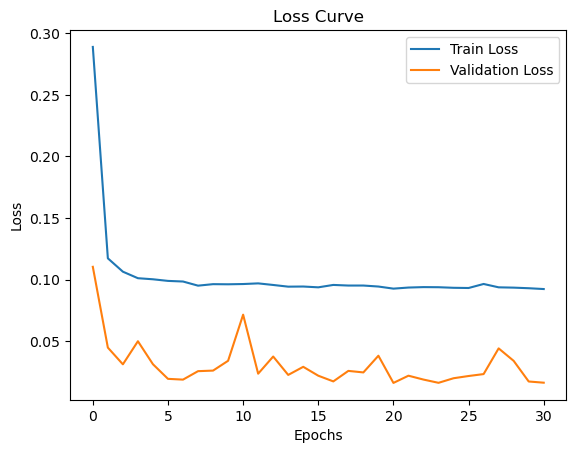

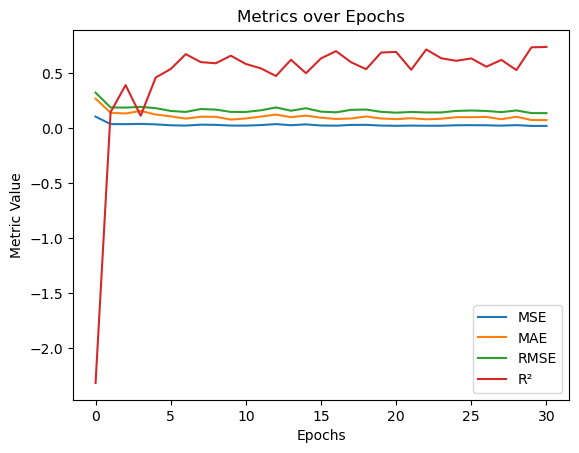

In [13]:
# Experiment 1: SimpleModel RNN Baseline
model = SimpleModel(input_size=5, hidden_size=128, output_size=5, num_layers=2, dropout=0.3, rnn_type='RNN')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

# Training
train_losses, val_losses, mse_values, mae_values, rmse_values, r2_values = train_and_evaluate(
    model, RNNData.train_loader, RNNData.val_loader, criterion, optimizer, num_epochs=100, patience=10)

plot_loss_curve(train_losses, val_losses)
plot_metrics(mse_values, mae_values, rmse_values, r2_values)


Epoch [1/100], Train Loss: 0.3223, Validation Loss: 0.0761, MSE: 0.0721, MAE: 0.2316, RMSE: 0.2686, R²: -1.9737
Epoch [2/100], Train Loss: 0.1172, Validation Loss: 0.0303, MSE: 0.0326, MAE: 0.1199, RMSE: 0.1806, R²: 0.2779
Epoch [3/100], Train Loss: 0.1092, Validation Loss: 0.0271, MSE: 0.0284, MAE: 0.1228, RMSE: 0.1686, R²: 0.3425
Epoch [4/100], Train Loss: 0.1034, Validation Loss: 0.0534, MSE: 0.0369, MAE: 0.1504, RMSE: 0.1920, R²: 0.1234
Epoch [5/100], Train Loss: 0.1005, Validation Loss: 0.0274, MSE: 0.0216, MAE: 0.0901, RMSE: 0.1469, R²: 0.6104
Epoch [6/100], Train Loss: 0.0979, Validation Loss: 0.0212, MSE: 0.0251, MAE: 0.1026, RMSE: 0.1585, R²: 0.4858
Epoch [7/100], Train Loss: 0.0979, Validation Loss: 0.0246, MSE: 0.0274, MAE: 0.1100, RMSE: 0.1656, R²: 0.4772
Epoch [8/100], Train Loss: 0.0987, Validation Loss: 0.0302, MSE: 0.0291, MAE: 0.1050, RMSE: 0.1707, R²: 0.5639
Epoch [9/100], Train Loss: 0.0976, Validation Loss: 0.0189, MSE: 0.0230, MAE: 0.0752, RMSE: 0.1516, R²: 0.6494


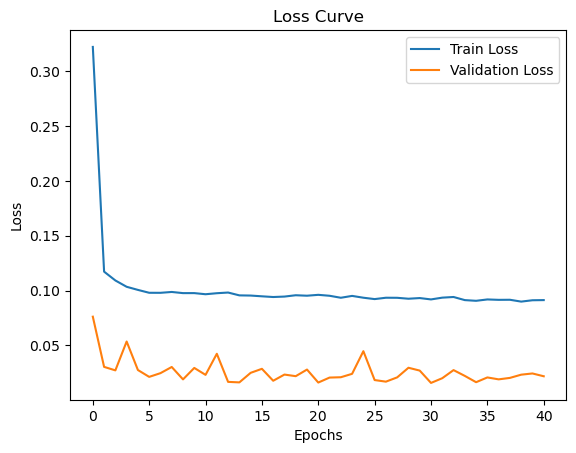

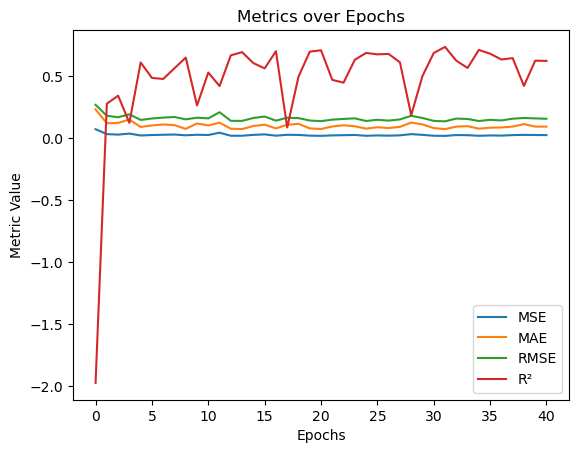

In [14]:
# Experiment 2: Model with dropout layers RNN Baseline
model = DropoutModel(input_size=5, hidden_size=128, output_size=5, num_layers=2, dropout=0.3, rnn_type='RNN')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

# Training
train_losses, val_losses, mse_values, mae_values, rmse_values, r2_values = train_and_evaluate(
    model, RNNData.train_loader, RNNData.val_loader, criterion, optimizer, num_epochs=100, patience=10)

plot_loss_curve(train_losses, val_losses)
plot_metrics(mse_values, mae_values, rmse_values, r2_values)

Epoch [1/100], Train Loss: 0.3518, Validation Loss: 0.0713, MSE: 0.0768, MAE: 0.2269, RMSE: 0.2771, R²: -0.8459
Epoch [2/100], Train Loss: 0.1358, Validation Loss: 0.0479, MSE: 0.0453, MAE: 0.1660, RMSE: 0.2128, R²: -0.0003
Epoch [3/100], Train Loss: 0.1261, Validation Loss: 0.0660, MSE: 0.0670, MAE: 0.2095, RMSE: 0.2588, R²: -0.4094
Epoch [4/100], Train Loss: 0.1199, Validation Loss: 0.0314, MSE: 0.0351, MAE: 0.1325, RMSE: 0.1872, R²: 0.3071
Epoch [5/100], Train Loss: 0.1071, Validation Loss: 0.0295, MSE: 0.0315, MAE: 0.1102, RMSE: 0.1776, R²: 0.5154
Epoch [6/100], Train Loss: 0.1045, Validation Loss: 0.0191, MSE: 0.0221, MAE: 0.0884, RMSE: 0.1487, R²: 0.6047
Epoch [7/100], Train Loss: 0.0995, Validation Loss: 0.0189, MSE: 0.0216, MAE: 0.0894, RMSE: 0.1470, R²: 0.5629
Epoch [8/100], Train Loss: 0.0973, Validation Loss: 0.0233, MSE: 0.0234, MAE: 0.0969, RMSE: 0.1528, R²: 0.5487
Epoch [9/100], Train Loss: 0.0979, Validation Loss: 0.0253, MSE: 0.0252, MAE: 0.1117, RMSE: 0.1589, R²: 0.507

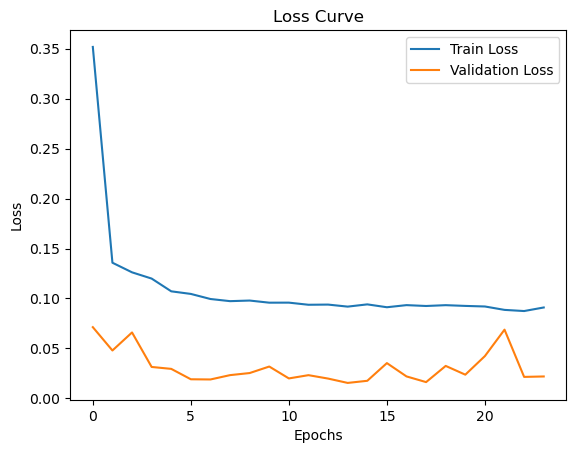

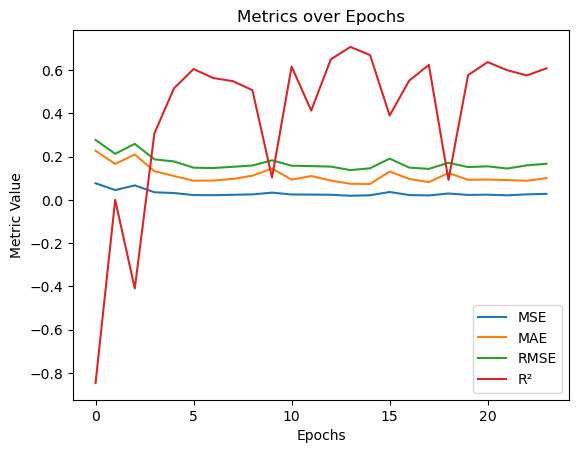

In [15]:
# Experiment 3: Model with fully connected layers RNN Baseline
model = FCLayerModel(input_size=5, hidden_size=128, output_size=5, num_layers=2, dropout=0.3, rnn_type='RNN')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

# Training
train_losses, val_losses, mse_values, mae_values, rmse_values, r2_values = train_and_evaluate(
    model, RNNData.train_loader, RNNData.val_loader, criterion, optimizer, num_epochs=100, patience=10)

plot_loss_curve(train_losses, val_losses)
plot_metrics(mse_values, mae_values, rmse_values, r2_values)

Epoch [1/100], Train Loss: 0.2869, Validation Loss: 0.0380, MSE: 0.0396, MAE: 0.1379, RMSE: 0.1990, R²: 0.0635
Epoch [2/100], Train Loss: 0.1090, Validation Loss: 0.0181, MSE: 0.0216, MAE: 0.0900, RMSE: 0.1469, R²: 0.5986
Epoch [3/100], Train Loss: 0.0981, Validation Loss: 0.0236, MSE: 0.0284, MAE: 0.1090, RMSE: 0.1686, R²: 0.5450
Epoch [4/100], Train Loss: 0.0968, Validation Loss: 0.0196, MSE: 0.0203, MAE: 0.0788, RMSE: 0.1423, R²: 0.6934
Epoch [5/100], Train Loss: 0.0963, Validation Loss: 0.0185, MSE: 0.0205, MAE: 0.0826, RMSE: 0.1433, R²: 0.6799
Epoch [6/100], Train Loss: 0.1038, Validation Loss: 0.0259, MSE: 0.0329, MAE: 0.1003, RMSE: 0.1814, R²: 0.4966
Epoch [7/100], Train Loss: 0.0970, Validation Loss: 0.0161, MSE: 0.0203, MAE: 0.0760, RMSE: 0.1426, R²: 0.6434
Epoch [8/100], Train Loss: 0.0966, Validation Loss: 0.0171, MSE: 0.0201, MAE: 0.0829, RMSE: 0.1416, R²: 0.6509
Epoch [9/100], Train Loss: 0.0964, Validation Loss: 0.0193, MSE: 0.0223, MAE: 0.0857, RMSE: 0.1492, R²: 0.6599
E

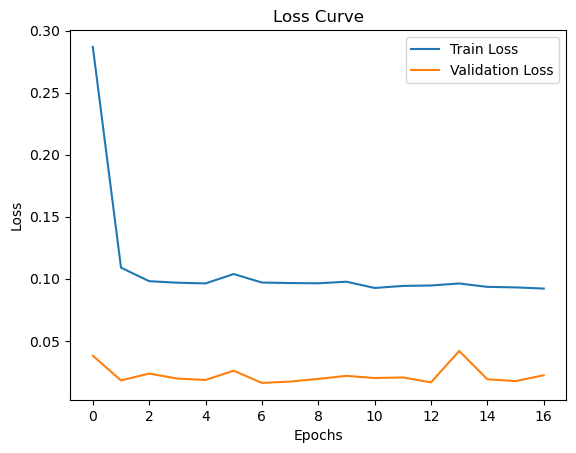

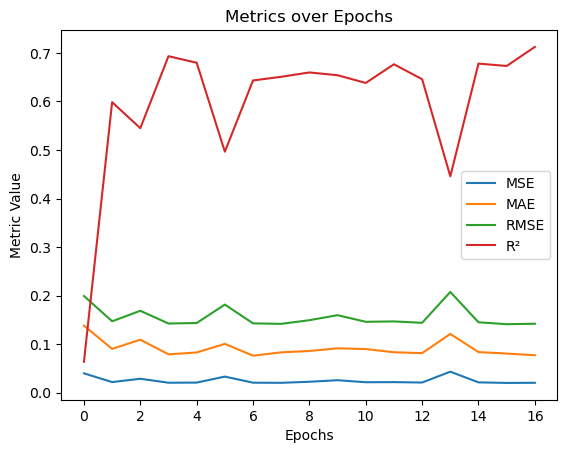

In [16]:
# Experiment 4: Model with multiple RNN layer RNN Baseline
model = MultiLayerModel(input_size=5, hidden_size=128, output_size=5, num_layers=2, dropout=0.3, rnn_type='RNN')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

# Training
train_losses, val_losses, mse_values, mae_values, rmse_values, r2_values = train_and_evaluate(
    model, RNNData.train_loader, RNNData.val_loader, criterion, optimizer, num_epochs=100, patience=10)

plot_loss_curve(train_losses, val_losses)
plot_metrics(mse_values, mae_values, rmse_values, r2_values)

In [17]:
class ImprovedRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.2, rnn_type='RNN'):  # rnn_type hinzugefügt
        super(ImprovedRNNModel, self).__init__()
        
        # Wähle RNN Typ basierend auf rnn_type Parameter
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                dropout=dropout,
                bidirectional=True
            )
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                dropout=dropout,
                bidirectional=True
            )
        else:  # Default RNN
            self.rnn = nn.RNN(
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                dropout=dropout,
                bidirectional=True
            )
            
        # Rest bleibt gleich
        self.batch_norm = nn.BatchNorm1d(hidden_size * 2)
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        rnn_out, _ = self.rnn(x)
        last_out = rnn_out[:, -1, :]
        last_out = self.batch_norm(last_out)
        out = F.relu(self.fc1(last_out))
        out = self.dropout(out)
        out = self.fc2(out)
        return out

Epoch [1/100], Train Loss: 0.2769, Validation Loss: 0.0914, MSE: 0.0879, MAE: 0.2631, RMSE: 0.2965, R²: -1.7808
Epoch [2/100], Train Loss: 0.1102, Validation Loss: 0.0185, MSE: 0.0221, MAE: 0.0935, RMSE: 0.1488, R²: 0.5853
Epoch [3/100], Train Loss: 0.0986, Validation Loss: 0.0251, MSE: 0.0279, MAE: 0.1137, RMSE: 0.1671, R²: 0.3446
Epoch [4/100], Train Loss: 0.1003, Validation Loss: 0.0243, MSE: 0.0299, MAE: 0.0953, RMSE: 0.1729, R²: 0.5162
Epoch [5/100], Train Loss: 0.0991, Validation Loss: 0.0422, MSE: 0.0462, MAE: 0.1475, RMSE: 0.2151, R²: 0.0846
Epoch [6/100], Train Loss: 0.0999, Validation Loss: 0.0187, MSE: 0.0234, MAE: 0.0995, RMSE: 0.1529, R²: 0.5461
Epoch [7/100], Train Loss: 0.0990, Validation Loss: 0.0769, MSE: 0.0208, MAE: 0.0745, RMSE: 0.1442, R²: 0.6508
Epoch [8/100], Train Loss: 0.0952, Validation Loss: 0.0158, MSE: 0.0195, MAE: 0.0720, RMSE: 0.1395, R²: 0.6915
Epoch [9/100], Train Loss: 0.0948, Validation Loss: 0.0213, MSE: 0.0244, MAE: 0.0983, RMSE: 0.1563, R²: 0.5838


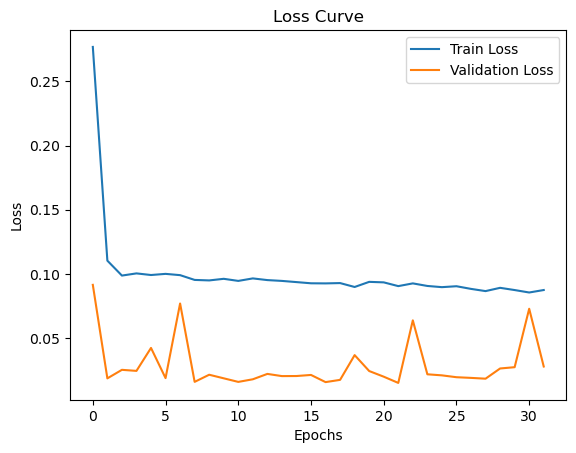

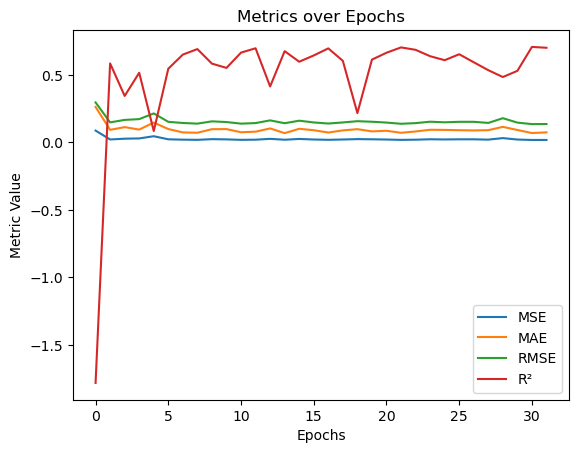

In [18]:
# Experiment 5: Improved model based on previous experiments RNN Baseline
model = ImprovedRNNModel(input_size=5, hidden_size=128, output_size=5, num_layers=2, dropout=0.3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

# Training
train_losses, val_losses, mse_values, mae_values, rmse_values, r2_values = train_and_evaluate(
    model, RNNData.train_loader, RNNData.val_loader, criterion, optimizer, num_epochs=100, patience=10)

plot_loss_curve(train_losses, val_losses)
plot_metrics(mse_values, mae_values, rmse_values, r2_values)

#### 2.3.2 Hyperparameter Optimisation

In [22]:
param_grid = {
    'input_size': [5],  # Fixed parameter
    'hidden_size': [64, 128, 256],
    'output_size': [5],  # Fixed parameter
    'num_layers': [2, 3],
    'dropout': [0.1, 0.2, 0.3],
    'optimizer': ['adam', 'sgd', 'rmsprop'],
    'learning_rate': [0.001, 0.01, 0.1]
}

# Initialisiere das Dictionary für die Ergebnisse
best_results = {}

# Optimierung für RNN
print(f"\nStarting optimization for RNN")
optimizer = HyperparameterOptimizer(DropoutModel, RNNData.train_loader, RNNData.val_loader, rnn_type='RNN')
optimizer.optimize(param_grid)
best_results['RNN'] = optimizer.get_best_results()
print(f"\nBest RNN parameters:", best_results['RNN']['best_parameters'])
print(f"Best RNN metrics:", best_results['RNN']['best_metrics'])


Starting optimization for RNN

optimize RNN model
Number of combinations: 162

Testing combination 1/162
Epoch [1/50], Train Loss: 0.4254, Validation Loss: 0.2298, MSE: 0.2226, MAE: 0.4409, RMSE: 0.4718, R²: -7.8639
Epoch [2/50], Train Loss: 0.1406, Validation Loss: 0.0769, MSE: 0.0821, MAE: 0.2395, RMSE: 0.2865, R²: -1.5295
Epoch [3/50], Train Loss: 0.1187, Validation Loss: 0.0415, MSE: 0.0412, MAE: 0.1588, RMSE: 0.2031, R²: -0.1426
Epoch [4/50], Train Loss: 0.1087, Validation Loss: 0.0400, MSE: 0.0369, MAE: 0.1514, RMSE: 0.1920, R²: 0.0358
Epoch [5/50], Train Loss: 0.1025, Validation Loss: 0.0219, MSE: 0.0275, MAE: 0.1184, RMSE: 0.1657, R²: 0.3845
Epoch [6/50], Train Loss: 0.1016, Validation Loss: 0.0305, MSE: 0.0333, MAE: 0.1188, RMSE: 0.1824, R²: 0.4602
Epoch [7/50], Train Loss: 0.1001, Validation Loss: 0.0311, MSE: 0.0224, MAE: 0.0886, RMSE: 0.1497, R²: 0.5900
Epoch [8/50], Train Loss: 0.0980, Validation Loss: 0.0244, MSE: 0.0256, MAE: 0.1102, RMSE: 0.1599, R²: 0.4533
Epoch [9/50

### 2.3 Gated Recurrent Unit (GRU)

Epoch [1/100], Train Loss: 0.3424, Validation Loss: 0.0499, MSE: 0.0366, MAE: 0.1223, RMSE: 0.1912, R²: 0.1527
Epoch [2/100], Train Loss: 0.1331, Validation Loss: 0.0368, MSE: 0.0384, MAE: 0.1412, RMSE: 0.1959, R²: 0.2886
Epoch [3/100], Train Loss: 0.1221, Validation Loss: 0.0225, MSE: 0.0282, MAE: 0.1188, RMSE: 0.1678, R²: 0.3281
Epoch [4/100], Train Loss: 0.1130, Validation Loss: 0.0315, MSE: 0.0323, MAE: 0.1203, RMSE: 0.1797, R²: 0.4319
Epoch [5/100], Train Loss: 0.1067, Validation Loss: 0.0628, MSE: 0.0277, MAE: 0.0963, RMSE: 0.1666, R²: 0.3900
Epoch [6/100], Train Loss: 0.1023, Validation Loss: 0.0311, MSE: 0.0295, MAE: 0.1175, RMSE: 0.1718, R²: 0.4740
Epoch [7/100], Train Loss: 0.0981, Validation Loss: 0.0196, MSE: 0.0214, MAE: 0.0856, RMSE: 0.1463, R²: 0.6367
Epoch [8/100], Train Loss: 0.0964, Validation Loss: 0.0206, MSE: 0.0215, MAE: 0.0851, RMSE: 0.1468, R²: 0.6621
Epoch [9/100], Train Loss: 0.0963, Validation Loss: 0.0239, MSE: 0.0216, MAE: 0.0869, RMSE: 0.1470, R²: 0.6490
E

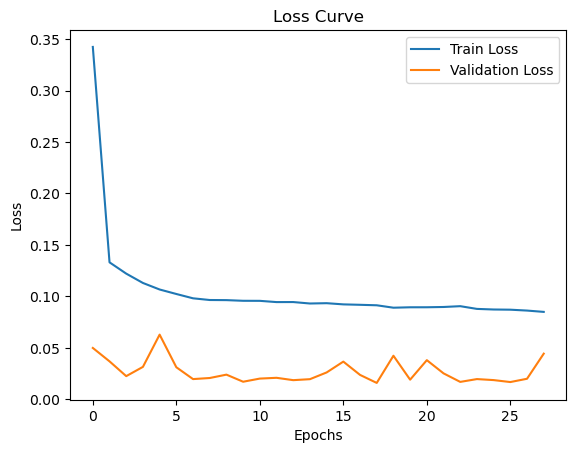

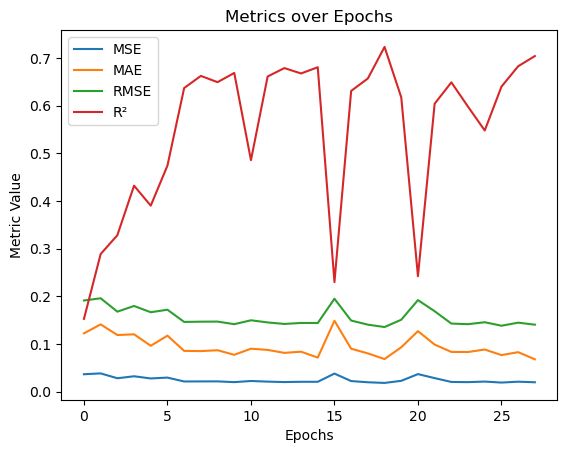

In [23]:
# Experiment 1: SimpleModel GRU
model = SimpleModel(input_size=5, hidden_size=128, output_size=5, num_layers=2, dropout=0.3, rnn_type='GRU')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

# Training
train_losses, val_losses, mse_values, mae_values, rmse_values, r2_values = train_and_evaluate(
    model, RNNData.train_loader, RNNData.val_loader, criterion, optimizer, num_epochs=100, patience=10)

plot_loss_curve(train_losses, val_losses)
plot_metrics(mse_values, mae_values, rmse_values, r2_values)


Epoch [1/100], Train Loss: 0.3385, Validation Loss: 0.0318, MSE: 0.0342, MAE: 0.1209, RMSE: 0.1848, R²: 0.1072
Epoch [2/100], Train Loss: 0.1346, Validation Loss: 0.0263, MSE: 0.0289, MAE: 0.1122, RMSE: 0.1701, R²: 0.3761
Epoch [3/100], Train Loss: 0.1214, Validation Loss: 0.0275, MSE: 0.0260, MAE: 0.1066, RMSE: 0.1612, R²: 0.4591
Epoch [4/100], Train Loss: 0.1147, Validation Loss: 0.0313, MSE: 0.0359, MAE: 0.1330, RMSE: 0.1894, R²: 0.3345
Epoch [5/100], Train Loss: 0.1096, Validation Loss: 0.0236, MSE: 0.0253, MAE: 0.1038, RMSE: 0.1592, R²: 0.5088
Epoch [6/100], Train Loss: 0.1042, Validation Loss: 0.0206, MSE: 0.0252, MAE: 0.1005, RMSE: 0.1587, R²: 0.5379
Epoch [7/100], Train Loss: 0.0993, Validation Loss: 0.0215, MSE: 0.0249, MAE: 0.1072, RMSE: 0.1579, R²: 0.4072
Epoch [8/100], Train Loss: 0.0993, Validation Loss: 0.0241, MSE: 0.0280, MAE: 0.1053, RMSE: 0.1674, R²: 0.5309
Epoch [9/100], Train Loss: 0.0977, Validation Loss: 0.0277, MSE: 0.0283, MAE: 0.1038, RMSE: 0.1682, R²: 0.5766
E

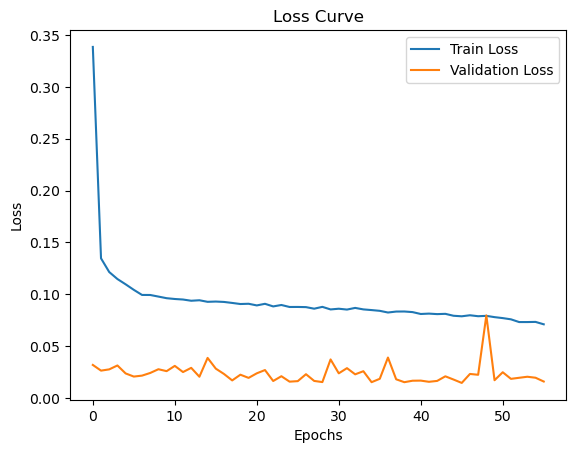

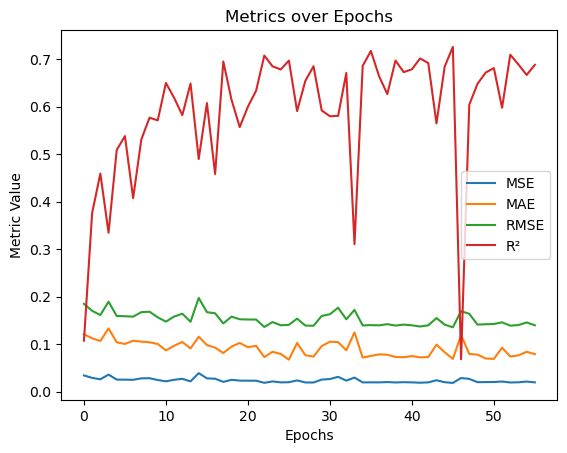

In [24]:
# Experiment 2: Model with dropout layers GRU
model = DropoutModel(input_size=5, hidden_size=128, output_size=5, num_layers=2, dropout=0.3, rnn_type='GRU')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

# Training
train_losses, val_losses, mse_values, mae_values, rmse_values, r2_values = train_and_evaluate(
    model, RNNData.train_loader, RNNData.val_loader, criterion, optimizer, num_epochs=100, patience=10)

plot_loss_curve(train_losses, val_losses)
plot_metrics(mse_values, mae_values, rmse_values, r2_values)

Epoch [1/100], Train Loss: 0.4609, Validation Loss: 0.1421, MSE: 0.1432, MAE: 0.3327, RMSE: 0.3784, R²: -5.3798
Epoch [2/100], Train Loss: 0.1538, Validation Loss: 0.0435, MSE: 0.0467, MAE: 0.1692, RMSE: 0.2160, R²: -0.2235
Epoch [3/100], Train Loss: 0.1318, Validation Loss: 0.0370, MSE: 0.0380, MAE: 0.1329, RMSE: 0.1950, R²: 0.3306
Epoch [4/100], Train Loss: 0.1215, Validation Loss: 0.0386, MSE: 0.0368, MAE: 0.1229, RMSE: 0.1920, R²: 0.4052
Epoch [5/100], Train Loss: 0.1129, Validation Loss: 0.0323, MSE: 0.0334, MAE: 0.1207, RMSE: 0.1826, R²: 0.3448
Epoch [6/100], Train Loss: 0.1084, Validation Loss: 0.0222, MSE: 0.0268, MAE: 0.1101, RMSE: 0.1637, R²: 0.4245
Epoch [7/100], Train Loss: 0.1000, Validation Loss: 0.0359, MSE: 0.0216, MAE: 0.0787, RMSE: 0.1469, R²: 0.6282
Epoch [8/100], Train Loss: 0.0984, Validation Loss: 0.0344, MSE: 0.0375, MAE: 0.1266, RMSE: 0.1937, R²: 0.4004
Epoch [9/100], Train Loss: 0.0984, Validation Loss: 0.0270, MSE: 0.0283, MAE: 0.1108, RMSE: 0.1681, R²: 0.4529

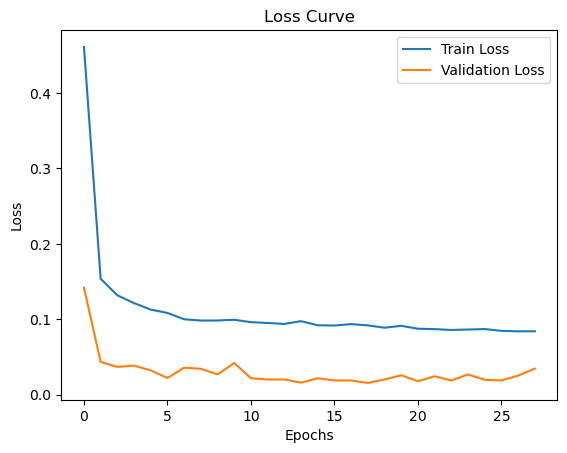

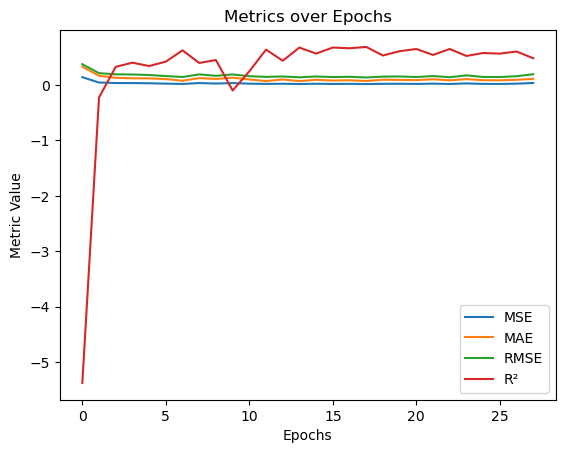

In [25]:
# Experiment 3: Model with fully connected layers GRU
model = FCLayerModel(input_size=5, hidden_size=128, output_size=5, num_layers=2, dropout=0.3, rnn_type='GRU')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

# Training
train_losses, val_losses, mse_values, mae_values, rmse_values, r2_values = train_and_evaluate(
    model, RNNData.train_loader, RNNData.val_loader, criterion, optimizer, num_epochs=100, patience=10)

plot_loss_curve(train_losses, val_losses)
plot_metrics(mse_values, mae_values, rmse_values, r2_values)

Epoch [1/100], Train Loss: 0.3513, Validation Loss: 0.0374, MSE: 0.0403, MAE: 0.1380, RMSE: 0.2007, R²: -0.5788
Epoch [2/100], Train Loss: 0.1263, Validation Loss: 0.0258, MSE: 0.0277, MAE: 0.1087, RMSE: 0.1665, R²: 0.4854
Epoch [3/100], Train Loss: 0.1100, Validation Loss: 0.0199, MSE: 0.0240, MAE: 0.0968, RMSE: 0.1550, R²: 0.4794
Epoch [4/100], Train Loss: 0.1023, Validation Loss: 0.0177, MSE: 0.0211, MAE: 0.0811, RMSE: 0.1453, R²: 0.6118
Epoch [5/100], Train Loss: 0.0989, Validation Loss: 0.0342, MSE: 0.0259, MAE: 0.0816, RMSE: 0.1608, R²: 0.5744
Epoch [6/100], Train Loss: 0.0974, Validation Loss: 0.0234, MSE: 0.0254, MAE: 0.1036, RMSE: 0.1593, R²: 0.5419
Epoch [7/100], Train Loss: 0.0987, Validation Loss: 0.0207, MSE: 0.0226, MAE: 0.0964, RMSE: 0.1504, R²: 0.6011
Epoch [8/100], Train Loss: 0.0967, Validation Loss: 0.0211, MSE: 0.0253, MAE: 0.0975, RMSE: 0.1592, R²: 0.5976
Epoch [9/100], Train Loss: 0.1003, Validation Loss: 0.0203, MSE: 0.0246, MAE: 0.0988, RMSE: 0.1570, R²: 0.5268


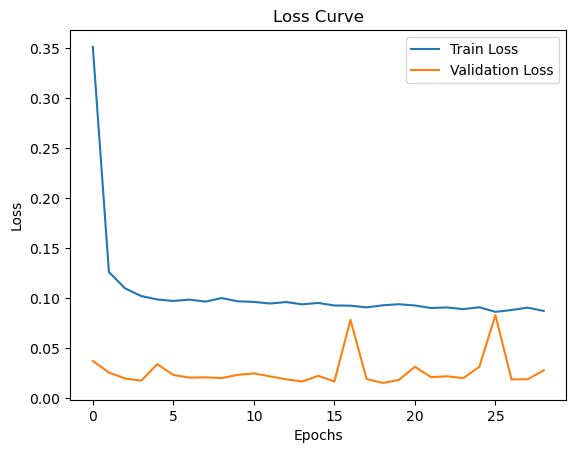

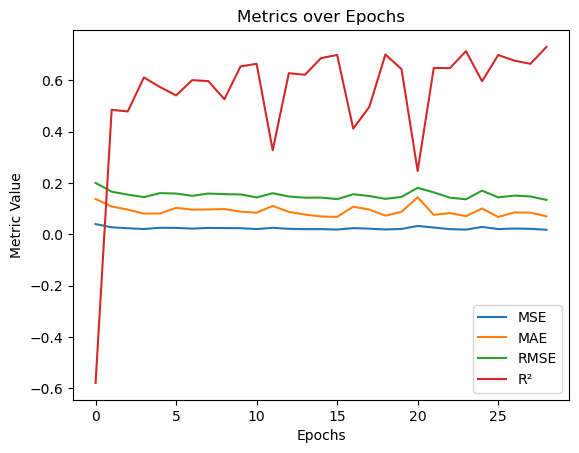

In [26]:
# Experiment 4: Model with multiple RNN layer GRU
model = MultiLayerModel(input_size=5, hidden_size=128, output_size=5, num_layers=2, dropout=0.3, rnn_type='GRU')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

# Training
train_losses, val_losses, mse_values, mae_values, rmse_values, r2_values = train_and_evaluate(
    model, RNNData.train_loader, RNNData.val_loader, criterion, optimizer, num_epochs=100, patience=10)

plot_loss_curve(train_losses, val_losses)
plot_metrics(mse_values, mae_values, rmse_values, r2_values)

In [27]:
class ImprovedGRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.2, rnn_type='GRU'):
        super(ImprovedGRUModel, self).__init__()
        
        # Bidirektionale GRU Layers mit Batch Norm
        self.rnn_layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        
        for i in range(num_layers):
            if rnn_type == 'GRU':
                rnn = nn.GRU(
                    input_size if i == 0 else hidden_size * 2,
                    hidden_size,
                    batch_first=True,
                    bidirectional=True
                )
            self.rnn_layers.append(rnn)
            self.batch_norms.append(nn.BatchNorm1d(hidden_size * 2))
        
        # Erweitertes FC Layer System
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.bn_fc1 = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.bn_fc2 = nn.BatchNorm1d(hidden_size // 2)
        self.fc_out = nn.Linear(hidden_size // 2, output_size)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # GRU Layer Durchlauf mit Batch Norm und Residual
        for i, (rnn, bn) in enumerate(zip(self.rnn_layers, self.batch_norms)):
            rnn_out, _ = rnn(x)
            # Batch Norm
            rnn_out = rnn_out.transpose(1, 2)
            rnn_out = bn(rnn_out)
            rnn_out = rnn_out.transpose(1, 2)
            # Dropout
            rnn_out = self.dropout(rnn_out)
            # Residual falls möglich
            if i > 0 and x.size() == rnn_out.size():
                x = x + rnn_out
            else:
                x = rnn_out
        
        # Nehme letzten Zeitschritt
        out = x[:, -1, :]
        
        # FC Layers mit Batch Norm und ReLU
        out = self.fc1(out)
        out = self.bn_fc1(out)
        out = F.relu(out)
        out = self.dropout(out)
        
        out = self.fc2(out)
        out = self.bn_fc2(out)
        out = F.relu(out)
        out = self.dropout(out)
        
        out = self.fc_out(out)
        
        return out

Epoch [1/100], Train Loss: 0.4186, Validation Loss: 0.3969, MSE: 0.3803, MAE: 0.5335, RMSE: 0.6167, R²: -12.1661
Epoch [2/100], Train Loss: 0.1518, Validation Loss: 0.0241, MSE: 0.0286, MAE: 0.1140, RMSE: 0.1691, R²: 0.4601
Epoch [3/100], Train Loss: 0.1100, Validation Loss: 0.0221, MSE: 0.0254, MAE: 0.1045, RMSE: 0.1595, R²: 0.5127
Epoch [4/100], Train Loss: 0.1070, Validation Loss: 0.0171, MSE: 0.0213, MAE: 0.0826, RMSE: 0.1459, R²: 0.6238
Epoch [5/100], Train Loss: 0.1010, Validation Loss: 0.0258, MSE: 0.0210, MAE: 0.0805, RMSE: 0.1449, R²: 0.6474
Epoch [6/100], Train Loss: 0.0982, Validation Loss: 0.0195, MSE: 0.0216, MAE: 0.0885, RMSE: 0.1468, R²: 0.6309
Epoch [7/100], Train Loss: 0.0972, Validation Loss: 0.0360, MSE: 0.0415, MAE: 0.1282, RMSE: 0.2037, R²: 0.3576
Epoch [8/100], Train Loss: 0.1014, Validation Loss: 0.0338, MSE: 0.0268, MAE: 0.1044, RMSE: 0.1638, R²: 0.5854
Epoch [9/100], Train Loss: 0.0985, Validation Loss: 0.0188, MSE: 0.0220, MAE: 0.0880, RMSE: 0.1484, R²: 0.5096

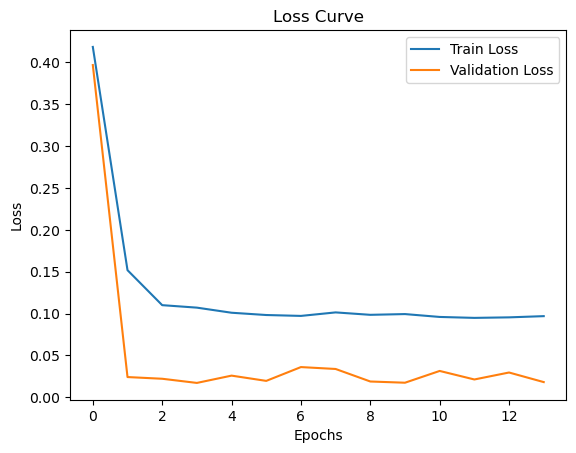

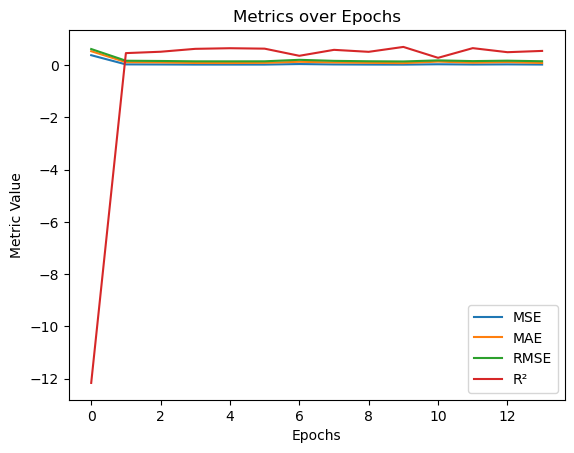

In [28]:
# Experiment 5: Improved model based on previous experiments GRU
model = ImprovedGRUModel(input_size=5, hidden_size=128, output_size=5, num_layers=2, dropout=0.3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

# Training
train_losses, val_losses, mse_values, mae_values, rmse_values, r2_values = train_and_evaluate(
    model, RNNData.train_loader, RNNData.val_loader, criterion, optimizer, num_epochs=100, patience=10)

plot_loss_curve(train_losses, val_losses)
plot_metrics(mse_values, mae_values, rmse_values, r2_values)

#### 2.3.2 Hyperparameter Optimisation

In [29]:
param_grid = {
    'input_size': [5],  # Fixed parameter
    'hidden_size': [64, 128, 256],
    'output_size': [5],  # Fixed parameter
    'num_layers': [2, 3],
    'dropout': [0.1, 0.2, 0.3],
    'optimizer': ['adam', 'sgd', 'rmsprop'],
    'learning_rate': [0.001, 0.01, 0.1]
}

best_results = {}

# Optimisation for GRU
print(f"\nStarting optimization for GRU")
optimizer = HyperparameterOptimizer(DropoutModel, RNNData.train_loader, RNNData.val_loader, rnn_type='GRU')
optimizer.optimize(param_grid)
best_results['GRU'] = optimizer.get_best_results()
print(f"\nBest GRU parameters:", best_results['GRU']['best_parameters'])
print(f"Best GRU metrics:", best_results['GRU']['best_metrics'])


Starting optimization for GRU

optimize GRU model
Number of combinations: 162

Testing combination 1/162
Epoch [1/50], Train Loss: 0.4227, Validation Loss: 0.1067, MSE: 0.1061, MAE: 0.2634, RMSE: 0.3257, R²: -2.5675
Epoch [2/50], Train Loss: 0.1469, Validation Loss: 0.0412, MSE: 0.0421, MAE: 0.1453, RMSE: 0.2052, R²: -0.0841
Epoch [3/50], Train Loss: 0.1327, Validation Loss: 0.0300, MSE: 0.0322, MAE: 0.1263, RMSE: 0.1795, R²: 0.2414
Epoch [4/50], Train Loss: 0.1252, Validation Loss: 0.0367, MSE: 0.0417, MAE: 0.1519, RMSE: 0.2042, R²: 0.1568
Epoch [5/50], Train Loss: 0.1198, Validation Loss: 0.0354, MSE: 0.0351, MAE: 0.1398, RMSE: 0.1874, R²: 0.2105
Epoch [6/50], Train Loss: 0.1121, Validation Loss: 0.0318, MSE: 0.0353, MAE: 0.1271, RMSE: 0.1880, R²: 0.4096
Epoch [7/50], Train Loss: 0.1083, Validation Loss: 0.0213, MSE: 0.0242, MAE: 0.0980, RMSE: 0.1557, R²: 0.5539
Epoch [8/50], Train Loss: 0.1033, Validation Loss: 0.0210, MSE: 0.0246, MAE: 0.1026, RMSE: 0.1569, R²: 0.5293
Epoch [9/50]

### 2.4 Long Short-Term Memory (LSTM)

Epoch [1/100], Train Loss: 0.4782, Validation Loss: 0.1000, MSE: 0.0934, MAE: 0.2371, RMSE: 0.3056, R²: -1.8370
Epoch [2/100], Train Loss: 0.1534, Validation Loss: 0.0416, MSE: 0.0389, MAE: 0.1395, RMSE: 0.1971, R²: 0.1281
Epoch [3/100], Train Loss: 0.1391, Validation Loss: 0.0447, MSE: 0.0472, MAE: 0.1512, RMSE: 0.2172, R²: 0.0707
Epoch [4/100], Train Loss: 0.1356, Validation Loss: 0.0336, MSE: 0.0362, MAE: 0.1296, RMSE: 0.1902, R²: 0.2770
Epoch [5/100], Train Loss: 0.1310, Validation Loss: 0.0343, MSE: 0.0354, MAE: 0.1272, RMSE: 0.1881, R²: 0.2223
Epoch [6/100], Train Loss: 0.1244, Validation Loss: 0.0617, MSE: 0.0358, MAE: 0.1261, RMSE: 0.1892, R²: 0.3052
Epoch [7/100], Train Loss: 0.1218, Validation Loss: 0.0313, MSE: 0.0367, MAE: 0.1372, RMSE: 0.1917, R²: 0.0697
Epoch [8/100], Train Loss: 0.1183, Validation Loss: 0.0227, MSE: 0.0269, MAE: 0.1048, RMSE: 0.1640, R²: 0.5217
Epoch [9/100], Train Loss: 0.1166, Validation Loss: 0.0316, MSE: 0.0315, MAE: 0.1204, RMSE: 0.1776, R²: 0.3114


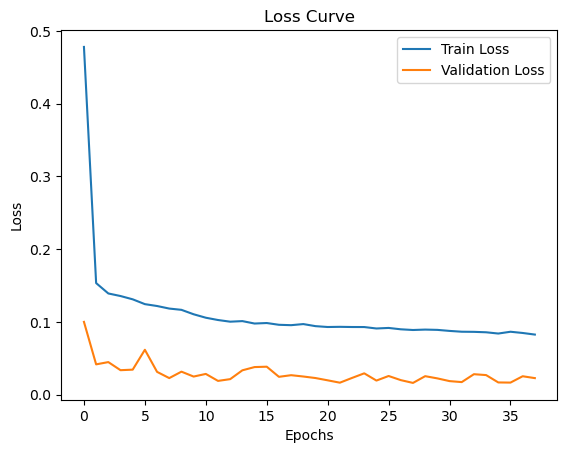

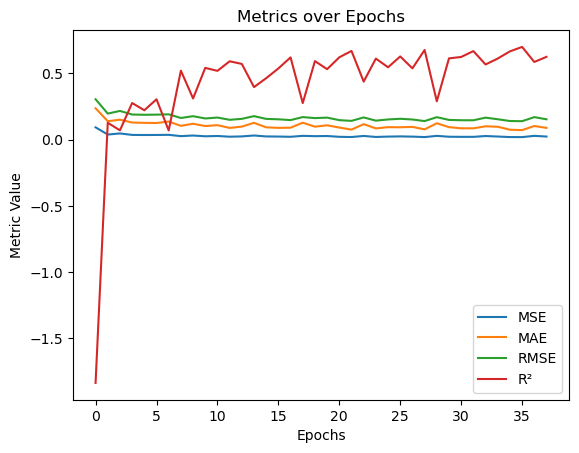

In [30]:
# Experiment 1: SimpleModel LSTM
model = SimpleModel(input_size=5, hidden_size=128, output_size=5, num_layers=2, dropout=0.3, rnn_type='LSTM')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

# Training
train_losses, val_losses, mse_values, mae_values, rmse_values, r2_values = train_and_evaluate(
    model, RNNData.train_loader, RNNData.val_loader, criterion, optimizer, num_epochs=100, patience=10)

plot_loss_curve(train_losses, val_losses)
plot_metrics(mse_values, mae_values, rmse_values, r2_values)


Epoch [1/100], Train Loss: 0.4974, Validation Loss: 0.0640, MSE: 0.0638, MAE: 0.2034, RMSE: 0.2526, R²: -0.8237
Epoch [2/100], Train Loss: 0.1606, Validation Loss: 0.0338, MSE: 0.0359, MAE: 0.1406, RMSE: 0.1893, R²: 0.1058
Epoch [3/100], Train Loss: 0.1418, Validation Loss: 0.0435, MSE: 0.0418, MAE: 0.1460, RMSE: 0.2045, R²: 0.0942
Epoch [4/100], Train Loss: 0.1368, Validation Loss: 0.0628, MSE: 0.0321, MAE: 0.1219, RMSE: 0.1791, R²: 0.2722
Epoch [5/100], Train Loss: 0.1313, Validation Loss: 0.0356, MSE: 0.0348, MAE: 0.1344, RMSE: 0.1866, R²: 0.2543
Epoch [6/100], Train Loss: 0.1306, Validation Loss: 0.0358, MSE: 0.0370, MAE: 0.1387, RMSE: 0.1924, R²: 0.2728
Epoch [7/100], Train Loss: 0.1263, Validation Loss: 0.0256, MSE: 0.0303, MAE: 0.1099, RMSE: 0.1742, R²: 0.3090
Epoch [8/100], Train Loss: 0.1224, Validation Loss: 0.0369, MSE: 0.0378, MAE: 0.1368, RMSE: 0.1945, R²: 0.1535
Epoch [9/100], Train Loss: 0.1188, Validation Loss: 0.0278, MSE: 0.0305, MAE: 0.1149, RMSE: 0.1746, R²: 0.3139


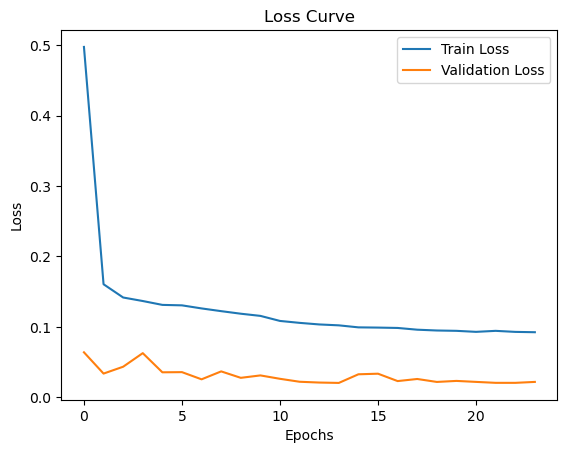

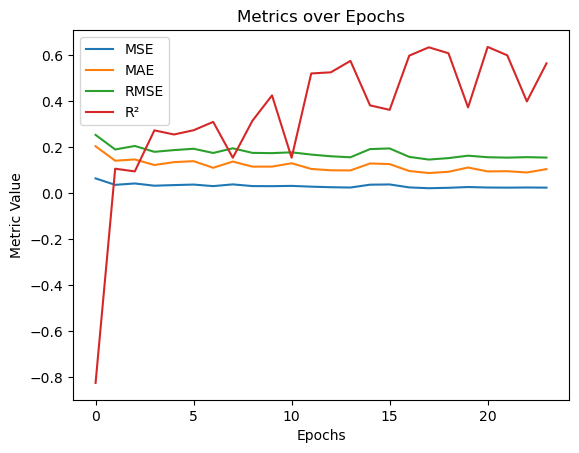

In [31]:
# Experiment 2: Model with dropout layers LSTM
model = DropoutModel(input_size=5, hidden_size=128, output_size=5, num_layers=2, dropout=0.3, rnn_type='LSTM')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

# Training
train_losses, val_losses, mse_values, mae_values, rmse_values, r2_values = train_and_evaluate(
    model, RNNData.train_loader, RNNData.val_loader, criterion, optimizer, num_epochs=100, patience=10)

plot_loss_curve(train_losses, val_losses)
plot_metrics(mse_values, mae_values, rmse_values, r2_values)

Epoch [1/100], Train Loss: 0.5975, Validation Loss: 0.3153, MSE: 0.3253, MAE: 0.5037, RMSE: 0.5704, R²: -11.5480
Epoch [2/100], Train Loss: 0.1796, Validation Loss: 0.0432, MSE: 0.0461, MAE: 0.1599, RMSE: 0.2146, R²: 0.0182
Epoch [3/100], Train Loss: 0.1433, Validation Loss: 0.0318, MSE: 0.0351, MAE: 0.1305, RMSE: 0.1874, R²: 0.2530
Epoch [4/100], Train Loss: 0.1353, Validation Loss: 0.0315, MSE: 0.0349, MAE: 0.1317, RMSE: 0.1869, R²: 0.2954
Epoch [5/100], Train Loss: 0.1365, Validation Loss: 0.0540, MSE: 0.0397, MAE: 0.1437, RMSE: 0.1993, R²: -0.0522
Epoch [6/100], Train Loss: 0.1310, Validation Loss: 0.0319, MSE: 0.0318, MAE: 0.1156, RMSE: 0.1784, R²: 0.3930
Epoch [7/100], Train Loss: 0.1301, Validation Loss: 0.0268, MSE: 0.0306, MAE: 0.1178, RMSE: 0.1749, R²: 0.4281
Epoch [8/100], Train Loss: 0.1273, Validation Loss: 0.0312, MSE: 0.0355, MAE: 0.1256, RMSE: 0.1885, R²: 0.3518
Epoch [9/100], Train Loss: 0.1223, Validation Loss: 0.0242, MSE: 0.0282, MAE: 0.1104, RMSE: 0.1678, R²: 0.438

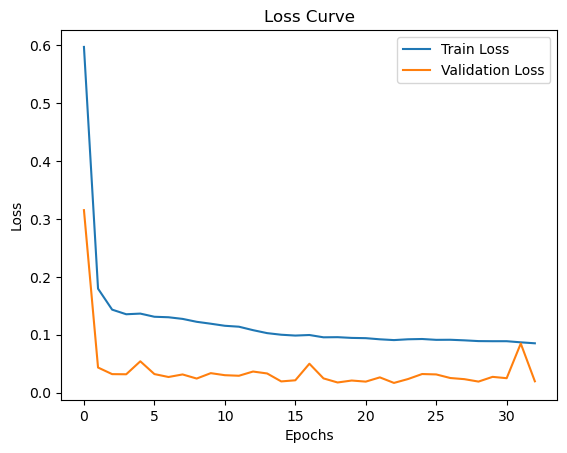

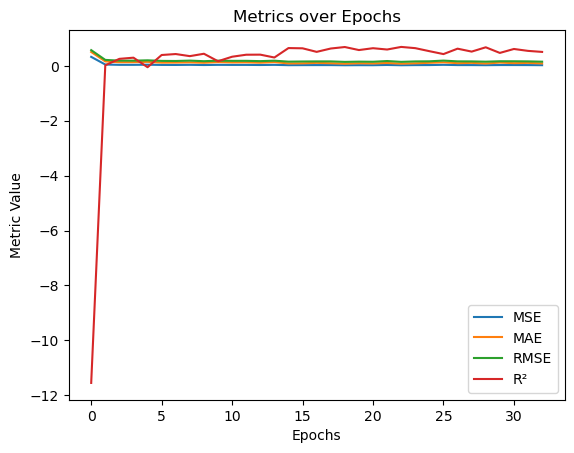

In [32]:
# Experiment 3: Model with fully connected layers LSTM
model = FCLayerModel(input_size=5, hidden_size=128, output_size=5, num_layers=2, dropout=0.3, rnn_type='LSTM')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

# Training
train_losses, val_losses, mse_values, mae_values, rmse_values, r2_values = train_and_evaluate(
    model, RNNData.train_loader, RNNData.val_loader, criterion, optimizer, num_epochs=100, patience=10)

plot_loss_curve(train_losses, val_losses)
plot_metrics(mse_values, mae_values, rmse_values, r2_values)

Epoch [1/100], Train Loss: 0.4666, Validation Loss: 0.0541, MSE: 0.0610, MAE: 0.1733, RMSE: 0.2470, R²: -0.7846
Epoch [2/100], Train Loss: 0.1410, Validation Loss: 0.0276, MSE: 0.0306, MAE: 0.1186, RMSE: 0.1750, R²: 0.3503
Epoch [3/100], Train Loss: 0.1270, Validation Loss: 0.0321, MSE: 0.0353, MAE: 0.1218, RMSE: 0.1879, R²: 0.3853
Epoch [4/100], Train Loss: 0.1153, Validation Loss: 0.0422, MSE: 0.0399, MAE: 0.1493, RMSE: 0.1998, R²: 0.0807
Epoch [5/100], Train Loss: 0.1054, Validation Loss: 0.0231, MSE: 0.0265, MAE: 0.1066, RMSE: 0.1629, R²: 0.4218
Epoch [6/100], Train Loss: 0.1064, Validation Loss: 0.0280, MSE: 0.0316, MAE: 0.1243, RMSE: 0.1777, R²: 0.1666
Epoch [7/100], Train Loss: 0.1004, Validation Loss: 0.0221, MSE: 0.0256, MAE: 0.1011, RMSE: 0.1599, R²: 0.4625
Epoch [8/100], Train Loss: 0.0997, Validation Loss: 0.0187, MSE: 0.0229, MAE: 0.0920, RMSE: 0.1514, R²: 0.4613
Epoch [9/100], Train Loss: 0.0985, Validation Loss: 0.0195, MSE: 0.0225, MAE: 0.0915, RMSE: 0.1501, R²: 0.4938


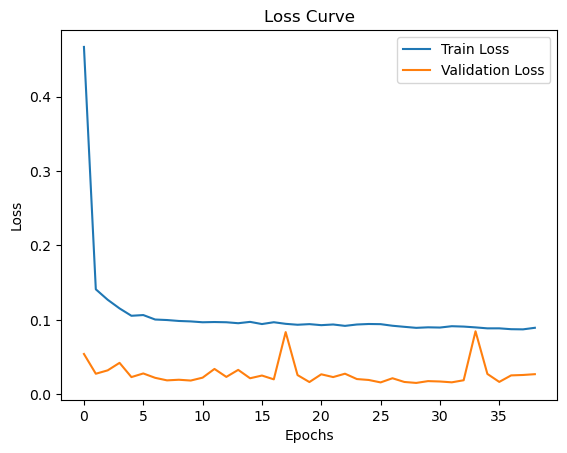

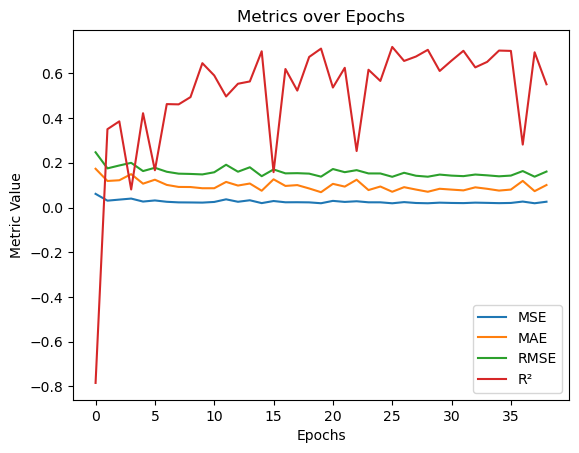

In [33]:
# Experiment 4: Model with multiple RNN layer LSTM
model = MultiLayerModel(input_size=5, hidden_size=128, output_size=5, num_layers=2, dropout=0.3, rnn_type='LSTM')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

# Training
train_losses, val_losses, mse_values, mae_values, rmse_values, r2_values = train_and_evaluate(
    model, RNNData.train_loader, RNNData.val_loader, criterion, optimizer, num_epochs=100, patience=10)

plot_loss_curve(train_losses, val_losses)
plot_metrics(mse_values, mae_values, rmse_values, r2_values)

#### 2.4.2 Hyperparameter Optimisation

In [34]:
param_grid = {
    'input_size': [5],  # Fixed parameter
    'hidden_size': [64, 128, 256],
    'output_size': [5],  # Fixed parameter
    'num_layers': [2, 3],
    'dropout': [0.1, 0.2, 0.3],
    'optimizer': ['adam', 'sgd', 'rmsprop'],
    'learning_rate': [0.001, 0.01, 0.1]
}

best_results = {}

# Optimisation for LSTM
print(f"\nStarting optimization for LSTM")
optimizer = HyperparameterOptimizer(SimpleModel, RNNData.train_loader, RNNData.val_loader, rnn_type='LSTM')
optimizer.optimize(param_grid)
best_results['LSTM'] = optimizer.get_best_results()
print(f"\nBest LSTM parameters:", best_results['LSTM']['best_parameters'])
print(f"Best LSTM metrics:", best_results['LSTM']['best_metrics'])



Starting optimization for LSTM

optimize LSTM model
Number of combinations: 162

Testing combination 1/162
Epoch [1/50], Train Loss: 0.6337, Validation Loss: 0.5155, MSE: 0.4937, MAE: 0.6428, RMSE: 0.7026, R²: -20.8413
Epoch [2/50], Train Loss: 0.1889, Validation Loss: 0.0408, MSE: 0.0458, MAE: 0.1641, RMSE: 0.2139, R²: -0.3571
Epoch [3/50], Train Loss: 0.1475, Validation Loss: 0.0380, MSE: 0.0428, MAE: 0.1528, RMSE: 0.2070, R²: 0.0579
Epoch [4/50], Train Loss: 0.1387, Validation Loss: 0.0339, MSE: 0.0394, MAE: 0.1411, RMSE: 0.1984, R²: 0.1803
Epoch [5/50], Train Loss: 0.1349, Validation Loss: 0.0410, MSE: 0.0408, MAE: 0.1406, RMSE: 0.2020, R²: 0.1327
Epoch [6/50], Train Loss: 0.1329, Validation Loss: 0.0428, MSE: 0.0382, MAE: 0.1365, RMSE: 0.1953, R²: 0.2274
Epoch [7/50], Train Loss: 0.1336, Validation Loss: 0.0382, MSE: 0.0315, MAE: 0.1187, RMSE: 0.1775, R²: 0.3409
Epoch [8/50], Train Loss: 0.1282, Validation Loss: 0.0377, MSE: 0.0428, MAE: 0.1479, RMSE: 0.2068, R²: -0.0562
Epoch [9

## 3. Results and Analysis

In [40]:
best_gru_params = {
    'input_size': 5,
    'hidden_size': 64,
    'output_size': 5,
    'num_layers': 3,
    'dropout': 0.3,
    'rnn_type': 'GRU',
    'optimizer': 'adam',
    'learning_rate': 0.001
}

In [46]:
def plot_final_results(results):
    # Subplots erstellen
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Verlustkurven (Train & Validation Loss) plotten
    axes[0].plot(results['train_history']['train_losses'], label='Train Loss')
    axes[0].plot(results['train_history']['val_losses'], label='Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()

    # Metriken (MSE, MAE, RMSE, R²) plotten
    axes[1].plot(results['train_history']['mse_values'], label='MSE')
    axes[1].plot(results['train_history']['mae_values'], label='MAE')
    axes[1].plot(results['train_history']['rmse_values'], label='RMSE')
    axes[1].plot(results['train_history']['r2_values'], label='R²')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Metric Value')
    axes[1].set_title('Metrics over Training')
    axes[1].legend()

    plt.tight_layout()
    plt.show()


In [50]:
# Final Test
def train_final_model(model_class, best_params, train_loader, val_loader, test_loader):
    optimizer_name = best_params.pop('optimizer', 'adam')
    learning_rate = best_params.pop('learning_rate', 0.001)
    
    model = model_class(**best_params)
    
    if optimizer_name == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer type: {optimizer_name}")
    
    criterion = nn.MSELoss()
    
    # Training
    train_losses, val_losses, mse_values, mae_values, rmse_values, r2_values = train_and_evaluate(
        model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=10
    )
    
    # Test Set Evaluation
    model.eval()
    test_loss, test_mse, test_mae, test_rmse, test_r2 = evaluate(model, test_loader, criterion)
    
    return {
        'model': model,
        'train_history': {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'mse_values': mse_values,
            'mae_values': mae_values,
            'rmse_values': rmse_values,
            'r2_values': r2_values
        },
        'test_metrics': {
            'loss': test_loss,
            'mse': test_mse,
            'mae': test_mae,
            'rmse': test_rmse,
            'r2': test_r2
        }
    }

final_results = train_final_model(
    DropoutModel,
    best_gru_params,
    RNNData.train_loader,
    RNNData.val_loader,
    RNNData.test_loader
)



Epoch [1/100], Train Loss: 0.4354, Validation Loss: 0.1449, MSE: 0.1554, MAE: 0.3553, RMSE: 0.3942, R²: -4.9661
Epoch [2/100], Train Loss: 0.1547, Validation Loss: 0.0397, MSE: 0.0374, MAE: 0.1401, RMSE: 0.1935, R²: 0.0528
Epoch [3/100], Train Loss: 0.1403, Validation Loss: 0.0352, MSE: 0.0305, MAE: 0.1159, RMSE: 0.1746, R²: 0.3246
Epoch [4/100], Train Loss: 0.1364, Validation Loss: 0.0400, MSE: 0.0393, MAE: 0.1452, RMSE: 0.1982, R²: 0.2463
Epoch [5/100], Train Loss: 0.1299, Validation Loss: 0.0271, MSE: 0.0296, MAE: 0.1233, RMSE: 0.1721, R²: 0.3582
Epoch [6/100], Train Loss: 0.1247, Validation Loss: 0.0336, MSE: 0.0349, MAE: 0.1208, RMSE: 0.1868, R²: 0.4262
Epoch [7/100], Train Loss: 0.1196, Validation Loss: 0.0325, MSE: 0.0361, MAE: 0.1328, RMSE: 0.1901, R²: 0.3464
Epoch [8/100], Train Loss: 0.1119, Validation Loss: 0.0869, MSE: 0.0260, MAE: 0.0994, RMSE: 0.1612, R²: 0.5463
Epoch [9/100], Train Loss: 0.1059, Validation Loss: 0.0178, MSE: 0.0219, MAE: 0.0851, RMSE: 0.1479, R²: 0.6131
